In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz

from graphviz import Source

import pydot


In [19]:
data = pd.read_csv('combined-naca.csv')
data.head(5)
print('Shape of features: ', data.shape)
data.describe()

Shape of features:  (3652, 8)


,Alpha,Cl,Cd,Cdp,Cm,Top_Xtr,Bot_Xtr,Naca
count,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000
mean,0.764239,0.253072,0.022089,0.016955,-0.041006,0.525791,0.561634,2310.521632
std,10.562997,0.967161,0.021333,0.021750,0.043580,0.397649,0.435943,1876.249303
min,-19.750000,-1.564400,0.003380,0.000730,-0.157400,0.003300,0.003200,6.000000
25%,-8.000000,-0.633650,0.008778,0.003210,-0.065600,0.074575,0.065575,21.000000
50%,1.000000,0.320150,0.013440,0.007820,-0.036300,0.537050,0.684850,2412.000000
75%,9.750000,1.202625,0.025755,0.020650,-0.004800,0.972025,1.000000,4412.000000
max,19.250000,1.708400,0.151610,0.149750,0.043200,1.000000,1.000000,6412.000000


In [20]:
# data = data.sort_values(by=['Naca', 'Alpha'])


In [21]:
# Split NACA into 4 digits:
# 1. First digit describing maximum camber as percentage of the chord.
# 2. Second digit describing the distance of maximum camber from the airfoil leading edge in tenths of the chord.
# 3. Last two digits describing maximum thickness of the airfoil as percent of the chord.

data['naca_1st'] = data['Naca'] // 1000
data['naca_2nd'] = data['Naca'] // 100 % 10
data['naca_3rd'] = data['Naca'] % 100

data.sample(n=10)

,Alpha,Cl,Cd,Cdp,Cm,Top_Xtr,Bot_Xtr,Naca,naca_1st,naca_2nd,naca_3rd
1643,9.25,0.9839,0.01740,0.01245,0.0063,0.0072,1.0000,8,0,0,8
1791,15.50,1.3403,0.04530,0.04178,0.0243,0.0076,1.0000,10,0,0,10
979,14.00,1.6325,0.03209,0.02620,-0.0516,0.0252,1.0000,4412,4,4,12
1377,10.50,1.4921,0.02254,0.01598,-0.0905,0.0139,1.0000,6409,6,4,9
2667,-4.00,-0.1895,0.00781,0.00228,-0.0566,0.9351,0.0557,2410,2,4,10
3423,0.50,0.2918,0.00814,0.00248,-0.0464,0.5078,0.5176,2421,2,4,21
186,-5.50,-0.5827,0.00922,0.00375,-0.0080,0.8077,0.2819,21,0,0,21
1200,-7.25,-0.2301,0.01043,0.00449,-0.1136,0.7348,0.1761,4424,4,4,24
2978,3.25,0.6318,0.00654,0.00208,-0.0563,0.4371,0.9972,2412,2,4,12
2919,-12.25,-1.1058,0.01971,0.01495,-0.0508,1.0000,0.0220,2412,2,4,12


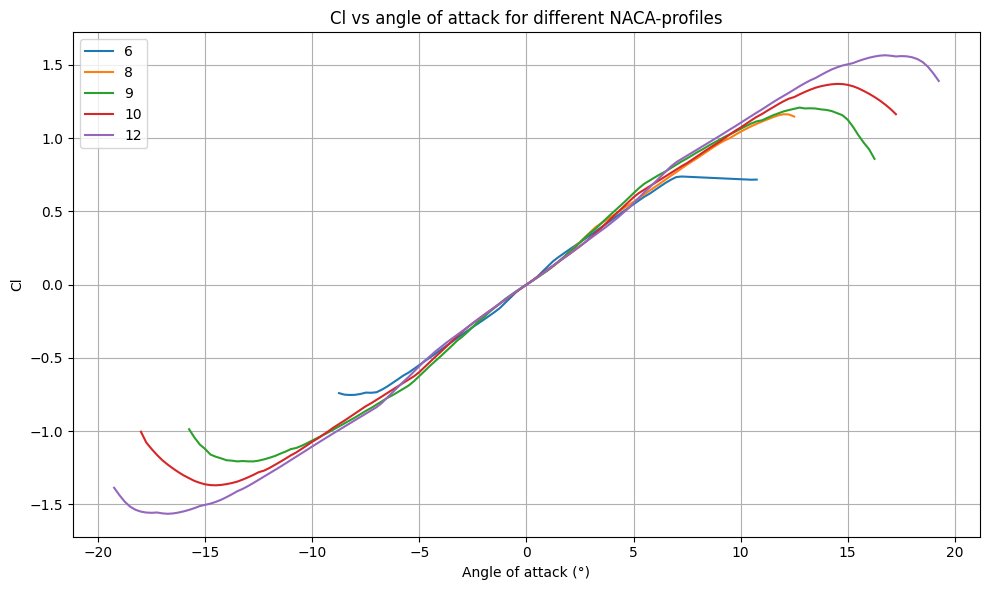

In [22]:


groups = data.groupby('Naca')

# Show some curves

plt.figure(figsize=(10,6))

coeff = 'Cl'
# coeff = 'Cd'

# for name, group in groups:
for name, group in islice(groups, 5):
    plt.plot(group['Alpha'], group[coeff],label=name )

plt.xlabel("Angle of attack (°)")
plt.ylabel(coeff)
plt.title(coeff + " vs angle of attack for different NACA-profiles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:

# Get all NACA numbers that are represented in the data
naca_unique = data.Naca.unique()

print('Unique NACAs: ', naca_unique, '\n')
print('Total size: ', naca_unique.size, '\n')

# Determine the share of data for training and testing
trainSetShare = 0.6
testSetShare = 0.38

# Number of NACA profiles for training, testing and validation
n_train = int(trainSetShare * len(naca_unique))
n_test = int(testSetShare * len(naca_unique))
n_valid = len(naca_unique)- n_test - n_train

print('Subset sizes:')
print('- training set:', n_train)
print('- test set:', n_test)
print('- validation set:', n_valid, '\n')

np.random.seed(4)
np.random.shuffle(naca_unique)

# Pointing out the specific NACA numbers chosen for each set
unique_train = naca_unique[:n_train]
unique_test = naca_unique[n_train:n_test+n_train]
unique_valid = naca_unique[n_test+n_train:]

print('- training set:', np.sort(unique_train))
print('- test set:', np.sort(unique_test))
print('- validation set:', np.sort(unique_valid))

Unique NACAs:  [   9   21 1410 2415 4415 4418 4412 4421 4424 6409 6412    6    8   10
   12   15   18 1408 1412 2408 2410 2411 2412 2414 2418 2421 2424] 

Total size:  27 

Subset sizes:
- training set: 16
- test set: 10
- validation set: 1 

- training set: [   6    8    9   15   18 1408 1410 2408 2410 2412 2415 2418 2421 4412
 4415 6412]
- test set: [  10   12   21 1412 2411 2414 4418 4421 4424 6409]
- validation set: [2424]


In [24]:
# Split dataset into training, test and validation set
set_train = data.loc[data['Naca'].isin(unique_train)]
set_test = data.loc[data['Naca'].isin(unique_test)]
set_valid = data.loc[data['Naca'].isin(unique_valid)]

In [25]:
features = ['Alpha', 'naca_1st', 'naca_2nd', 'naca_3rd']
label = ['Cl', 'Cd', 'Cdp', 'Cm', 'Top_Xtr', 'Bot_Xtr']

label = ['Cl', 'Cd']

In [26]:
feature_train = set_train[features]
label_train = set_train[label]

feature_test = set_test[features]
label_test = set_test[label]

feature_valid = set_valid[features]
label_valid = set_valid[label]

feature_test

# plt.figure(figsize=(10,6))

# coeff = 'Cl'

# # for name, group in groups:
# for name, group in groups:
#     if name in unique_test:
#         plt.plot(group['Alpha'], group[coeff],label=name )

# plt.xlabel("Angle of attack (°)")
# plt.ylabel(coeff)
# plt.title(coeff + " vs angle of attack for different NACA-profiles")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

,Alpha,naca_1st,naca_2nd,naca_3rd
129,-19.75,0,0,21
130,-19.50,0,0,21
131,-19.25,0,0,21
132,-19.00,0,0,21
133,-18.75,0,0,21
...,...,...,...,...
3187,18.25,2,4,14
3188,18.50,2,4,14
3189,18.75,2,4,14
3190,19.00,2,4,14


In [27]:
print('Training Features Shape:', feature_train.shape)
print('Training Labels Shape:', label_train.shape)
print('Testing Features Shape:', feature_test.shape)
print('Testing Labels Shape:', label_test.shape)
print('Validation Features Shape:', feature_valid.shape)
print('Validation Labels Shape:', label_valid.shape)
print(feature_test,label_test)

Training Features Shape: (2044, 4)
Training Labels Shape: (2044, 2)
Testing Features Shape: (1453, 4)
Testing Labels Shape: (1453, 2)
Validation Features Shape: (155, 4)
Validation Labels Shape: (155, 2)
      Alpha  naca_1st  naca_2nd  naca_3rd
129  -19.75         0         0        21
130  -19.50         0         0        21
131  -19.25         0         0        21
132  -19.00         0         0        21
133  -18.75         0         0        21
...     ...       ...       ...       ...
3187  18.25         2         4        14
3188  18.50         2         4        14
3189  18.75         2         4        14
3190  19.00         2         4        14
3191  19.25         2         4        14

[1453 rows x 4 columns]           Cl       Cd
129  -1.3432  0.07827
130  -1.3520  0.07412
131  -1.3588  0.07026
132  -1.3630  0.06671
133  -1.3640  0.06359
...      ...      ...
3187  1.5058  0.07299
3188  1.4989  0.07728
3189  1.4897  0.08192
3190  1.4802  0.08669
3191  1.4697  0.09170

[1

In [28]:

# Instantiate model with 7 decision trees
rf = RandomForestRegressor(n_estimators=7, random_state=25)

# Train the model on training data
rf.fit(feature_train, label_train);

In [29]:
predictions = rf.predict(feature_test)

print(predictions.shape)
print(set_test.shape)

# Absolute errors
errors = abs(predictions -  label_test)

# Mean absolute error
print('Mean Absolute Error: ', round(np.mean(errors), 2), 'degrees')
predictions

(1453, 2)
(1453, 11)
Mean Absolute Error:  0.04 degrees


array([[-1.31965714,  0.08770857],
       [-1.32874286,  0.08331429],
       [-1.3348    ,  0.08062286],
       ...,
       [ 1.48235714,  0.08233286],
       [ 1.47402857,  0.08503143],
       [ 1.47421429,  0.08552286]], shape=(1453, 2))

In [30]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / abs(label_test))

# Accuracy
accuracy = 100 - np.mean(mape)

print('Accuracy: ', round(accuracy, 2), '%')

Accuracy:  82.41 %


In [31]:
# Calculate R2
r2_Cl = r2_score(label_test['Cl'], predictions[:,0])
r2_Cd = r2_score(label_test['Cd'], predictions[:,1])

print('R-squared for predictions:')
print(f"- Cl: r2 = {r2_Cl:.3f}")
print(f"- Cd: r2 = {r2_Cd:.3f}")

R-squared for predictions:
- Cl: r2 = 0.988
- Cd: r2 = 0.787


In [32]:
# # Pull out one tree from the forest
# #tree = rf.estimators_[5]
# # Pull out one tree from the forest
# tree = rf.estimators_[0]
# ## Export the image to a dot file

# dot_file_path = 'random_forest_tree.dot'

# export_graphviz(
#     tree,
#     out_file = dot_file_path,
#     feature_names = features,
#     rounded = True,
#     precision = 1)

# with open(dot_file_path) as f:
#     dot_graph = f.read()

# #Visualize the tree using graphviz
# graph = Source(dot_graph)
# graph.render("random_forest_tree")
# graph #Display the tree graph

3497    2
3498    2
3499    2
3500    2
3501    2
       ..
3647    2
3648    2
3649    2
3650    2
3651    2
Name: naca_1st, Length: 155, dtype: int64
3497    4
3498    4
3499    4
3500    4
3501    4
       ..
3647    4
3648    4
3649    4
3650    4
3651    4
Name: naca_2nd, Length: 155, dtype: int64
3497    24
3498    24
3499    24
3500    24
3501    24
        ..
3647    24
3648    24
3649    24
3650    24
3651    24
Name: naca_3rd, Length: 155, dtype: int64


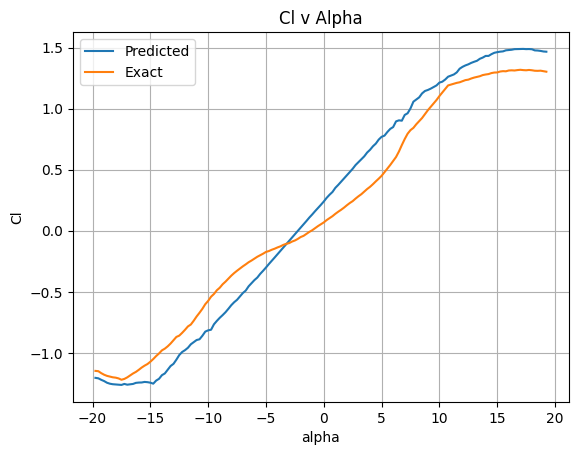

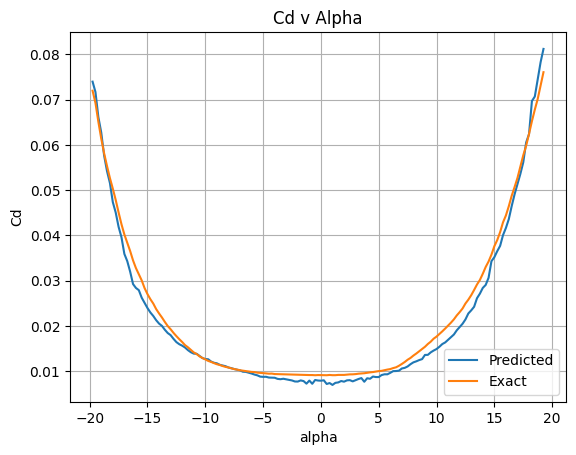

In [33]:
# Make a prediction for with the validation data and plot it
prediction = rf.predict(feature_valid)
alpha = feature_valid['Alpha']

np.squeeze(prediction)

print(feature_valid['naca_1st'])
print(feature_valid['naca_2nd'])
print(feature_valid['naca_3rd'])

exact = label_valid['Cl']
plt.figure()
plt.plot(alpha,prediction[:,0])
plt.plot(alpha,exact)
plt.grid();
plt.xlabel('alpha');
plt.ylabel('Cl');
plt.title('Cl v Alpha')
plt.legend(['Predicted', 'Exact'])

exact = label_valid['Cd']
plt.figure()
plt.plot(alpha,prediction[:,1])
plt.plot(alpha,exact)
plt.grid();
plt.xlabel('alpha');
plt.ylabel('Cd');
plt.title('Cd v Alpha')
plt.legend(['Predicted', 'Exact'])


